In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
import os
import cv2

def load_images(dirname, grayscale=False, size=None):
    mode = 0 if grayscale else 1
    images = []
    
    for filename in os.listdir(dirname):        
        image = cv2.imread(os.path.join(dirname, filename), mode)
        
        if size is not None:
            image = cv2.resize(image, size)
        
        images.append(image)
    
    return images

In [0]:
def prepare_data(c, nc, expand_dims=False, normalize=False, return_y=False):
    c  = np.array(c) if type(c) == list else c
    nc = np.array(nc) if type(nc) == list else nc
    
    X = np.concatenate((c, nc), axis=0)
    
    if expand_dims:
        X = np.expand_dims(X, axis=3)
    
    if normalize:
        X = X.astype(np.float32) / 255
    
    if return_y:
        c_target  = np.ones(c.shape[0])
        nc_target = np.zeros(nc.shape[0])
        
        y = np.concatenate((c_target, nc_target), axis=0)
        
        return X, y
    
    return X

In [0]:
c_train  = load_images('./Dataset/Train/C', size=(64, 64))
nc_train = load_images('./Dataset/Train/NC', size=(64, 64))

In [0]:
X, y = prepare_data(c_train, nc_train, normalize=True, return_y=True)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), input_shape=(None, None, X_train.shape[3])))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4)))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 32)    128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 32)    128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    18496     
__________

In [8]:
training = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

Train on 4809 samples, validate on 535 samples
Epoch 1/30
4809/4809 [==============================] - 8s 2ms/step - loss: 0.3420 - acc: 0.8850 - val_loss: 0.5380 - val_acc: 0.7364
Epoch 2/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.2469 - acc: 0.9235 - val_loss: 0.3453 - val_acc: 0.8785
Epoch 3/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.2225 - acc: 0.9357 - val_loss: 1.7984 - val_acc: 0.5645
Epoch 4/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.2002 - acc: 0.9412 - val_loss: 0.2872 - val_acc: 0.9009
Epoch 5/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.1972 - acc: 0.9418 - val_loss: 0.2371 - val_acc: 0.9159
Epoch 6/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.1825 - acc: 0.9449 - val_loss: 0.3010 - val_acc: 0.8879
Epoch 7/30
4809/4809 [==============================] - 6s 1ms/step - loss: 0.1797 - acc: 0.9480 - val_loss: 3.7210 - val_acc: 0.5103
Epoch 8/30
4809

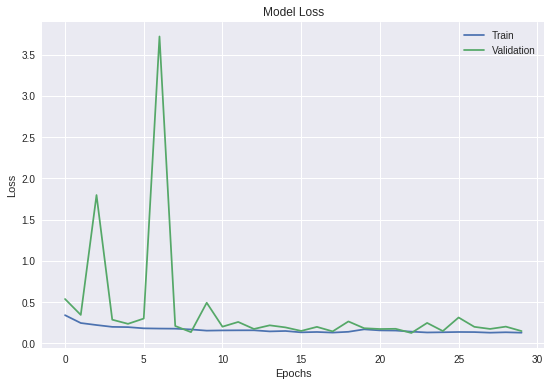

In [9]:
plt.figure(figsize=(9,6))
plt.plot(training.history['loss'], label='Train')
plt.plot(training.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

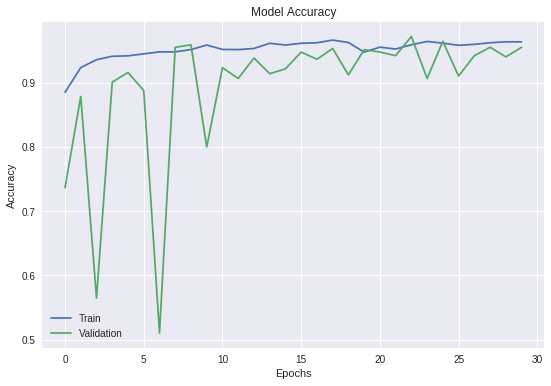

In [10]:
plt.figure(figsize=(9,6))
plt.plot(training.history['acc'], label='Train')
plt.plot(training.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
c_test  = load_images('./Dataset/Test/C', size=(64, 64))
nc_test = load_images('./Dataset/Test/NC', size=(64, 64))

In [0]:
X_test, y_test = prepare_data(c_test, nc_test, normalize=True, return_y=True)

In [13]:
model.evaluate(X_test, y_test)

1336/1336 [==============================] - 1s 508us/step


[0.15945663584206632, 0.9558383237102075]

In [0]:
model.save_weights('weights.hdf5')